### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

### Load and visualize data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

In [ ]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
print(f"categories shape: {categories.shape} , Type: {categories.dtype}")
print(f"training_data shape: {training_data.shape} , Type: {training_data.dtype}")
print(f"valid_periods shape: {valid_periods.shape} , Type: {valid_periods.dtype}")

categories shape: (48000,) , Type: <U1
training_data shape: (48000, 2776) , Type: float64
valid_periods shape: (48000, 2) , Type: int64


In [ ]:
training_data

array([[0.        , 0.        , 0.        , ..., 0.60277778, 0.36759259,
        0.33148148],
       [0.        , 0.        , 0.        , ..., 0.6       , 0.46      ,
        0.396     ],
       [0.        , 0.        , 0.        , ..., 0.96048126, 0.94650625,
        0.97714021],
       ...,
       [0.        , 0.        , 0.        , ..., 0.52631579, 0.58223684,
        0.55263158],
       [0.        , 0.        , 0.        , ..., 0.44559585, 0.58549223,
        0.40414508],
       [0.        , 0.        , 0.        , ..., 0.54268293, 0.6097561 ,
        0.59146341]])

### Split data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

In [ ]:
ohencoder = OneHotEncoder(sparse=False)
categories = ohencoder.fit_transform(categories.reshape(-1,1))

#### Split

In [ ]:
#np.random.shuffle(training_data)
train_split = np.random.choice(len(training_data), int(len(training_data) * 0.9), replace=False)
test_split = [x for x in range(len(training_data)) if x not in train_split]
training, test = training_data[train_split,:], training_data[test_split,:]
training_cats, test_cats = categories[train_split, :], categories[test_split, :]
training_valid_p, test_valid_p = valid_periods[train_split, :], valid_periods[test_split, :]


training.shape, test.shape

((43200, 2776), (4800, 2776))

In [ ]:
# given the categories, split into training and validation data with a stratified split of 90/10
from sklearn.model_selection import train_test_split

training, test, training_valid_p, test_valid_p, training_cats, test_cats = train_test_split(training_data, valid_periods, categories, test_size=0.1, stratify=categories)
training, val, training_valid_p, val_valid_p, training_cats, val_cats = train_test_split(training, training_valid_p, training_cats, test_size=0.1, stratify=training_cats)

In [ ]:
training.shape, training_valid_p.shape, training_cats.shape

((38880, 2776), (38880, 2), (38880, 6))

In [ ]:
import numpy as np

def generate_pairs(categories, training_data, valid_periods, window=200, stride=4, telescope=18):
    pairs = []

    for i, category in enumerate(categories):
        valid_period = valid_periods[i]
        data = training_data[i]
        data[:valid_period[0]] = -1.0

        for j in range(len(data) - window + 1, valid_period[0], -stride):
            output_sequence = data[j - telescope : (j + 1)]
            input_sequence = data[j - telescope - window : j - telescope]

            # Check if the input sequence has at least one valid value
            if np.any(input_sequence >= 0):  # Assuming padded values are represented by negative values
                pairs.append([input_sequence, output_sequence, category])
            else:
                break

    return pairs

#pairs = generate_pairs(categories, training_data, valid_periods)

In [ ]:
# Define Transformer hyperparameters
window = 200
stride = 2
telescope = 18
latent_dim = 1024
num_heads = 4

In [ ]:
def to_sequences(data, cats, validp):
    x = []
    cat = []
    y = []
    print(len(training_cats))

    for i, category in enumerate(cats):
        valid_period = validp[i]
        data_p = data[i]
        data_p[:valid_period[0] + 1] = -1.0

        for j in range(len(data_p) - window + 1, valid_period[0], -stride):
            output_sequence = data_p[j - telescope : j]
            input_sequence = data_p[j - telescope - window : j - telescope]
            # Check if the input sequence has at least one valid value
            if np.any(input_sequence >= 0):  # Assuming padded values are represented by negative values
                x.append(input_sequence)
                cat.append(category)
                y.append(output_sequence)
            else:
                break

    return np.expand_dims(np.array(x), axis=-1), np.array(cat), np.expand_dims(np.array(y), axis=-1)



x_train, x_train_cat, y_train = to_sequences(training, training_cats, training_valid_p)
x_val, x_val_cat, y_val = to_sequences(val, val_cats, val_valid_p)
x_test, x_test_cat, y_test = to_sequences(test, test_cats, test_valid_p)

38880
38880
38880


In [ ]:
input_shape = x_train.shape[1:]
cat_shape = x_train_cat.shape[1:]
input_shape, cat_shape

((200, 1), (6,))

In [ ]:
x_train.shape, x_val.shape, x_test.shape

((872328, 200, 1), (91276, 200, 1), (105010, 200, 1))

#### Model

This notebook contains the implementation of the Informer model. We used the implementation of manjimnav, available at https://github.com/manjimnav/Informer-Tensorflow

In [ ]:
"""class PositionEmbedding(tfkl.Layer):
    def __init__(self, window, **kwargs):
        super().__init__(**kwargs)
        self.pos_emb = tfkl.Embedding(input_dim=window, output_dim=window)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions"""

'class PositionEmbedding(tfkl.Layer):\n    def __init__(self, window, **kwargs):\n        super().__init__(**kwargs)\n        self.pos_emb = tfkl.Embedding(input_dim=window, output_dim=window)\n\n    def call(self, x):\n        maxlen = tf.shape(x)[-1]\n        positions = tf.range(start=0, limit=maxlen, delta=1)\n        positions = self.pos_emb(positions)\n        return x + positions'

In [ ]:
def create_padding_mask(inputs):
    mask = tf.math.greater_equal(inputs, 0.0)  # Check for padding value (-1)
    mask = tf.cast(mask, dtype=tf.float32)  # Convert True/False to 1.0/0.0
    return mask

In [ ]:
class ProbSparseSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(ProbSparseSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.depth = d_model // self.num_heads

        # Defining the dense layers for Query, Key and Value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Fixing matrix multiplication
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        d_k = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(concat_attention)

In [ ]:
class InformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, conv_filters, **kwargs):
        super(InformerEncoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.self_attention = ProbSparseSelfAttention(d_model=d_model, num_heads=num_heads)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # This dense layer will transform the input 'x' to have the dimensionality 'd_model'
        self.dense_transform = tf.keras.layers.Dense(d_model)

        self.conv1 = tf.keras.layers.Conv1D(conv_filters, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv1D(d_model, 3, padding='same')
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, x):
        attn_output = self.self_attention(x, x, x)

        # Transform 'x' to have the desired dimensionality
        x_transformed = self.dense_transform(x)
        attn_output = self.norm1(attn_output + x_transformed)

        conv_output = self.conv1(attn_output)
        conv_output = tf.nn.relu(conv_output)
        conv_output = self.conv2(conv_output)

        encoded_output = self.norm2(conv_output + attn_output)

        pooled_output = self.global_avg_pooling(encoded_output)
        return self.dense(pooled_output)[:, -18:]

In [ ]:
input_layer = tf.keras.layers.Input(shape=(200, 1))

# Encoder
encoder_output = InformerEncoder(d_model=360, num_heads=8, conv_filters=64)(input_layer)

# Decoder (with attention)
decoder_lstm = tf.keras.layers

In [ ]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Bidirectional, LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def InformerModel(input_shape, d_model=128, num_heads=4, conv_filters=512, decoder_size=512, learning_rate= 1e-3):
    # Input
    input_layer = Input(shape=input_shape)

    # Encoder
    encoder_output = InformerEncoder(d_model=d_model, num_heads=num_heads, conv_filters=conv_filters)(input_layer)

    # Decoder
    repeated_output = RepeatVector(18)(encoder_output)  # Repeating encoder's output
    decoder_lstm = Bidirectional(LSTM(decoder_size, return_sequences=True), merge_mode='sum')(repeated_output)
    decoder_output = Dense(18)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)
    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')



    return model

model = InformerModel(input_shape=(200, 1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=["mse", "mae"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 informer_encoder_4 (Inform  (None, 18)                428416    
 erEncoder)                                                      
                                                                 
 repeat_vector_2 (RepeatVec  (None, 18, 18)            0         
 tor)                                                            
                                                                 
 bidirectional (Bidirection  (None, 18, 512)           2174976   
 al)                                                             
                                                                 
 tf.__operators__.getitem_2  (None, 512)               0         
  (SlicingOpLambda)                                        

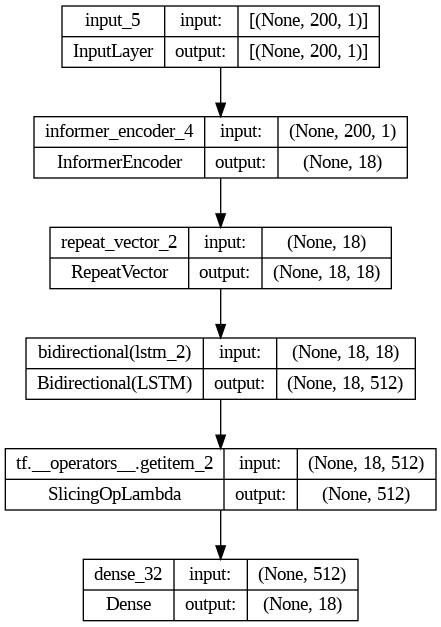

In [ ]:
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
EPOCHS = 10

history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data = (x_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.1, min_lr=1e-5)
    ]
)

Epoch 1/10
6816/6816 [==============================] - 419s 60ms/step - loss: 0.0125 - mse: 0.0125 - mae: 0.0755 - val_loss: 0.0092 - val_mse: 0.0092 - val_mae: 0.0628 - lr: 0.0010
Epoch 2/10
6816/6816 [==============================] - 414s 61ms/step - loss: 0.0090 - mse: 0.0090 - mae: 0.0619 - val_loss: 0.0089 - val_mse: 0.0089 - val_mae: 0.0625 - lr: 0.0010
Epoch 3/10
6816/6816 [==============================] - 408s 60ms/step - loss: 0.0086 - mse: 0.0086 - mae: 0.0600 - val_loss: 0.0087 - val_mse: 0.0087 - val_mae: 0.0593 - lr: 0.0010
Epoch 4/10
6816/6816 [==============================] - 415s 61ms/step - loss: 0.0083 - mse: 0.0083 - mae: 0.0587 - val_loss: 0.0084 - val_mse: 0.0084 - val_mae: 0.0592 - lr: 0.0010
Epoch 5/10
6816/6816 [==============================] - 408s 60ms/step - loss: 0.0082 - mse: 0.0082 - mae: 0.0579 - val_loss: 0.0082 - val_mse: 0.0082 - val_mae: 0.0580 - lr: 0.0010
Epoch 6/10
6816/6816 [==============================] - 413s 61ms/step - loss: 0.0080 - ms

In [ ]:
model.save('encoder_cat_w200__')

In [ ]:
history = history.history

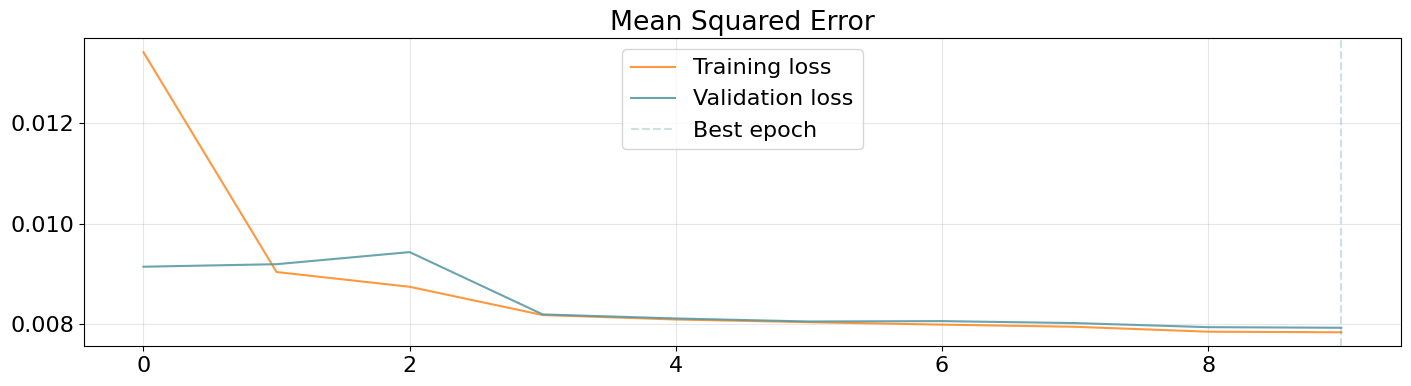

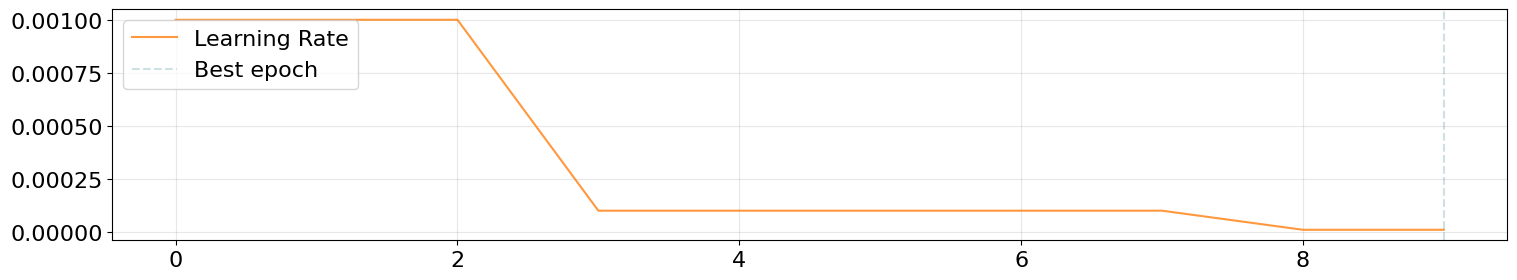

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Predict the test set using the model
predictions = model.predict(x_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (105010, 18)
Mean Squared Error: 0.007429754827171564
Mean Absolute Error: 0.054363735020160675


In [ ]:
def inspect_univariate_prediction(X, y, pred, telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))

    pred = np.concatenate([np.expand_dims(X[:, -1], axis=1), pred.squeeze()], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1], axis=1), y.squeeze()], axis=1)

    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(np.arange(len(X[0])), X[idx])
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), y[idx], color='orange')
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), pred[idx], color='green')
    ax.set_title('Prediction vs Actual')
    ax.set_ylim(0, 1)
    plt.show()


In [ ]:
x_test.shape, y_test.shape, predictions.shape

((105010, 200, 1), (105010, 18, 1), (105010, 18))

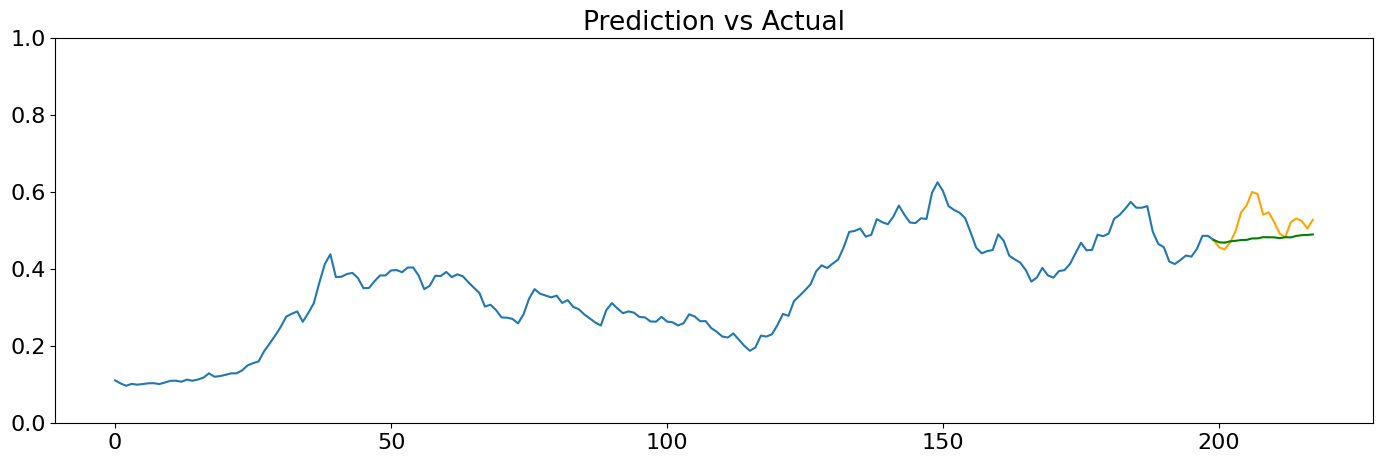

In [ ]:
inspect_univariate_prediction(x_test.squeeze(), y_test.squeeze(), predictions, telescope)